# DATA LODING

In [1]:
%pip install numpy pandas matplotlib seaborn opencv-python scikit-learn tensorflow

In [5]:
# Core Python Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import cv2
import matplotlib.image as mpimg
import seaborn as sns
import random
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
%matplotlib inline
plt.style.use('ggplot')

# EDA

In [3]:
import os
listyes = os.listdir("C:\\BRAIN_TUMOR_CLASSIFICATION\\yes")
number_files_yes = len(listyes)
print(number_files_yes)

listno = os.listdir("C:\\BRAIN_TUMOR_CLASSIFICATION\\no")
number_files_no = len(listno)
print(number_files_no)

155
98


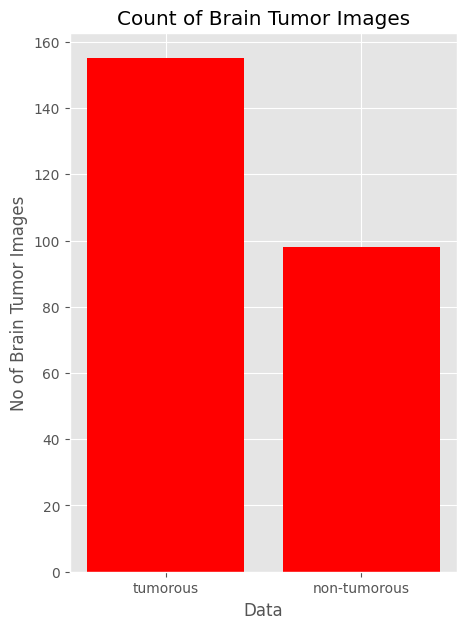

In [6]:

data = {'tumorous': number_files_yes, 'non-tumorous': number_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(5,7))

plt.bar(typex, values, color="red")

plt.xlabel("Data")
plt.ylabel("No of Brain Tumor Images")
plt.title("Count of Brain Tumor Images")
plt.show()

# DATA ARGUMENTATION

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import optuna
from optuna.samplers import TPESampler

In [8]:
def timing(sec_elapsed):
    h = int(sec_elapsed / (60*60))
    m = int(sec_elapsed % (60*60) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{s}"

In [9]:
def augmented_data(file_dir, n_generated_samples, save_to_dir):
    # Ensure the save directory exists
    os.makedirs(save_to_dir, exist_ok=True)
    data_gen = ImageDataGenerator(rotation_range=10, 
                      width_shift_range=0.1,
                      height_shift_range=0.1,
                      shear_range=0.1,
                      brightness_range=(0.3, 1.0),
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='nearest')
    for filename in os.listdir(file_dir):
        file_path = os.path.join(file_dir, filename)
        image = cv2.imread(file_path)
        if image is None:
            print(f"Warning: could not read {file_path}; skipping.")
            continue
        # If grayscale, convert to BGR so shapes are consistent
        if len(image.shape) == 2:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        image = image.reshape((1,) + image.shape)
        save_prefix = 'aug_' + os.path.splitext(filename)[0]
        i = 0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir, save_prefix=save_prefix, save_format="jpg"):
            i += 1
            # generate exactly n_generated_samples per input image
            if i >= n_generated_samples:
                break

In [10]:
import time
import os
import cv2
start_time = time.time()

# Use os.path.join for cross-platform-safe path construction
base_dir = r'C:\BRAIN_TUMOR_CLASSIFICATION'
yes_path = os.path.join(base_dir, 'yes')
no_path = os.path.join(base_dir, 'no')

augmented_data_path = os.path.join(base_dir, 'augmented_data')
# Ensure output folders exist
os.makedirs(os.path.join(augmented_data_path, 'yes'), exist_ok=True)
os.makedirs(os.path.join(augmented_data_path, 'no'), exist_ok=True)

augmented_data(file_dir=yes_path, n_generated_samples=6, save_to_dir=os.path.join(augmented_data_path, 'yes'))
augmented_data(file_dir=no_path, n_generated_samples=9, save_to_dir=os.path.join(augmented_data_path, 'no'))

end_time = time.time()
execution_time = end_time - start_time
print(timing(execution_time))

0:1:8.69286060333252


In [11]:
def data_summary(main_path):
    yes_path = "augmented_data/yes/" 
    no_path = "augmented_data/no/"
    
    n_pos = len(os.listdir(yes_path))
    n_neg = len(os.listdir(no_path))
    
    n = (n_pos + n_neg)
    
    pos_per = (n_pos*100)/n
    neg_per = (n_neg*100)/n
    
    print(f"Number of sample: {n}")
    print(f"{n_pos} Number of positive sample in percentage: {pos_per}%")
    print(f"{n_neg} Number of negative sample in percentage: {neg_per}%")

In [12]:
data_summary(augmented_data_path)

Number of sample: 3621
1859 Number of positive sample in percentage: 51.33940900303784%
1762 Number of negative sample in percentage: 48.66059099696216%


In [14]:
listyes = os.listdir("augmented_data/yes/")
number_files_yes = len(listyes)
print(number_files_yes)

listno = os.listdir("augmented_data/no/")
number_files_no = len(listno)
print(number_files_no)

1859
1762


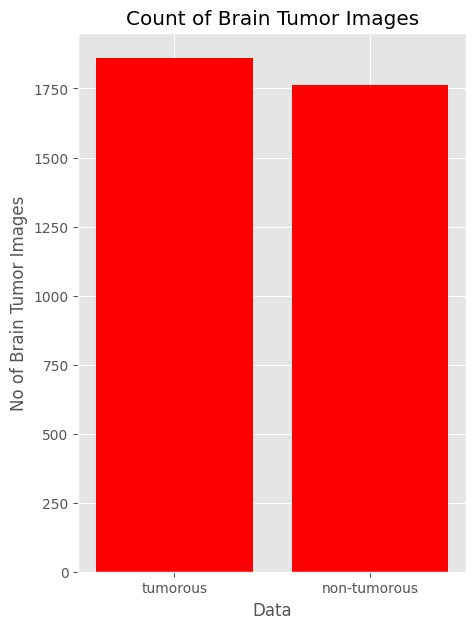

In [15]:
import matplotlib.pyplot as plt
data = {'tumorous': number_files_yes, 'non-tumorous': number_files_no}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(5,7))

plt.bar(typex, values, color="red")

plt.xlabel("Data")
plt.ylabel("No of Brain Tumor Images")
plt.title("Count of Brain Tumor Images")
plt.show()

# DATA PREPROCESSING

In [17]:
%pip install imutils

In [18]:
import imutils
def crop_brain_tumor(image, plot=False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5,5), 0)
    
    thres = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thres =cv2.erode(thres, None, iterations = 2)
    thres = cv2.dilate(thres, None, iterations = 2)
    
    cnts = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key = cv2.contourArea)
    
    extLeft = tuple(c[c[:,:,0].argmin()][0])
    extRight = tuple(c[c[:,:,0].argmax()][0])
    extTop = tuple(c[c[:,:,1].argmin()][0])
    extBot = tuple(c[c[:,:,1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]] 
    
    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        plt.show()
    return new_image

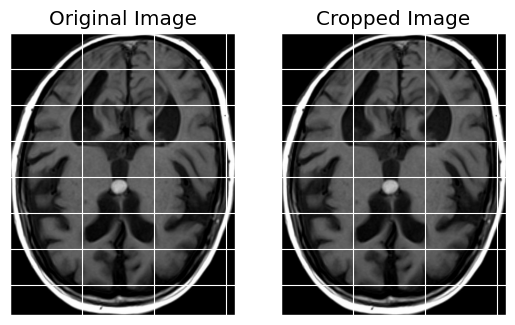

array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ...,

       [[ 1,  1,  1],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[17, 17, 17],
        [10, 10, 10],
        [ 6,  6,  6],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [13, 13, 13],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]]], shape=(783, 625, 3), dtype=uint8)

In [19]:
import random

# Select a random image from augmented_data/yes folder
random_image = random.choice(os.listdir('augmented_data/yes'))
img = cv2.imread(f'augmented_data/yes/{random_image}')
crop_brain_tumor(img, True)

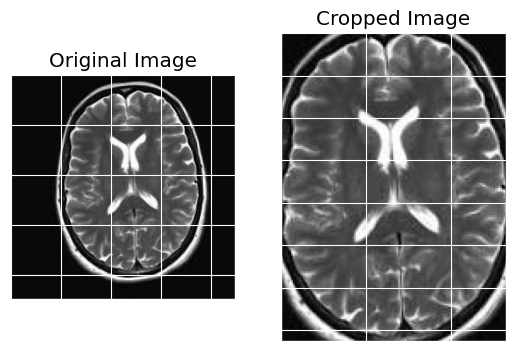

array([[[9, 9, 9],
        [9, 9, 9],
        [9, 9, 9],
        ...,
        [9, 9, 9],
        [9, 9, 9],
        [9, 9, 9]],

       [[9, 9, 9],
        [9, 9, 9],
        [9, 9, 9],
        ...,
        [9, 9, 9],
        [9, 9, 9],
        [9, 9, 9]],

       [[9, 9, 9],
        [9, 9, 9],
        [9, 9, 9],
        ...,
        [9, 9, 9],
        [9, 9, 9],
        [9, 9, 9]],

       ...,

       [[9, 9, 9],
        [9, 9, 9],
        [9, 9, 9],
        ...,
        [9, 9, 9],
        [9, 9, 9],
        [9, 9, 9]],

       [[9, 9, 9],
        [9, 9, 9],
        [9, 9, 9],
        ...,
        [9, 9, 9],
        [9, 9, 9],
        [9, 9, 9]],

       [[9, 9, 9],
        [9, 9, 9],
        [9, 9, 9],
        ...,
        [9, 9, 9],
        [9, 9, 9],
        [9, 9, 9]]], shape=(182, 133, 3), dtype=uint8)

In [20]:
import random

# Select a random image from augmented_data/no folder
random_image = random.choice(os.listdir('augmented_data/no'))
img = cv2.imread(f'augmented_data/no/{random_image}')
crop_brain_tumor(img, True)

In [21]:
folder1 = 'augmented_data/no/'
folder2 = 'augmented_data/yes/'

for filename in os.listdir(folder1):
    img = cv2.imread(folder1 + filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(folder1 + filename, img)
for filename in os.listdir(folder2):
    img = cv2.imread(folder2 + filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(folder2 + filename, img)

# IMAGE LOADING

In [22]:
from sklearn.utils import shuffle
def load_data(dir_list, image_size):
    X=[]
    y=[]
    
    image_width, image_height=image_size
    
    for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv2.imread(directory + '/' + filename)
            image = crop_brain_tumor(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation = cv2.INTER_CUBIC)
            image = image/255.00
            X.append(image)
            if directory[-3:] == "yes":
                y.append(1)
            else:
                y.append(0)
    X=np.array(X)
    y=np.array(y)
    
    X,y = shuffle(X,y)
    print(f"Number of example is : {len(X)}")
    print(f"X SHAPE is : {X.shape}")
    print(f"y SHAPE is : {y.shape}")
    return X,y

In [23]:
import numpy as np

augmented_path = 'augmented_data/'
augmeneted_yes = augmented_path + 'yes'
augmeneted_no = augmented_path + 'no'

IMAGE_WIDTH, IMAGE_HEIGHT = (240,240)

X,y = load_data([augmeneted_yes, augmeneted_no], (IMAGE_WIDTH, IMAGE_HEIGHT))

Number of example is : 3621
X SHAPE is : (3621, 240, 240, 3)
y SHAPE is : (3621,)


In [24]:
def plot_sample_images(X, y, n=50):

    for label in [0,1]:
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                            labelbottom=False, labeltop=False, labelleft=False,
                            labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

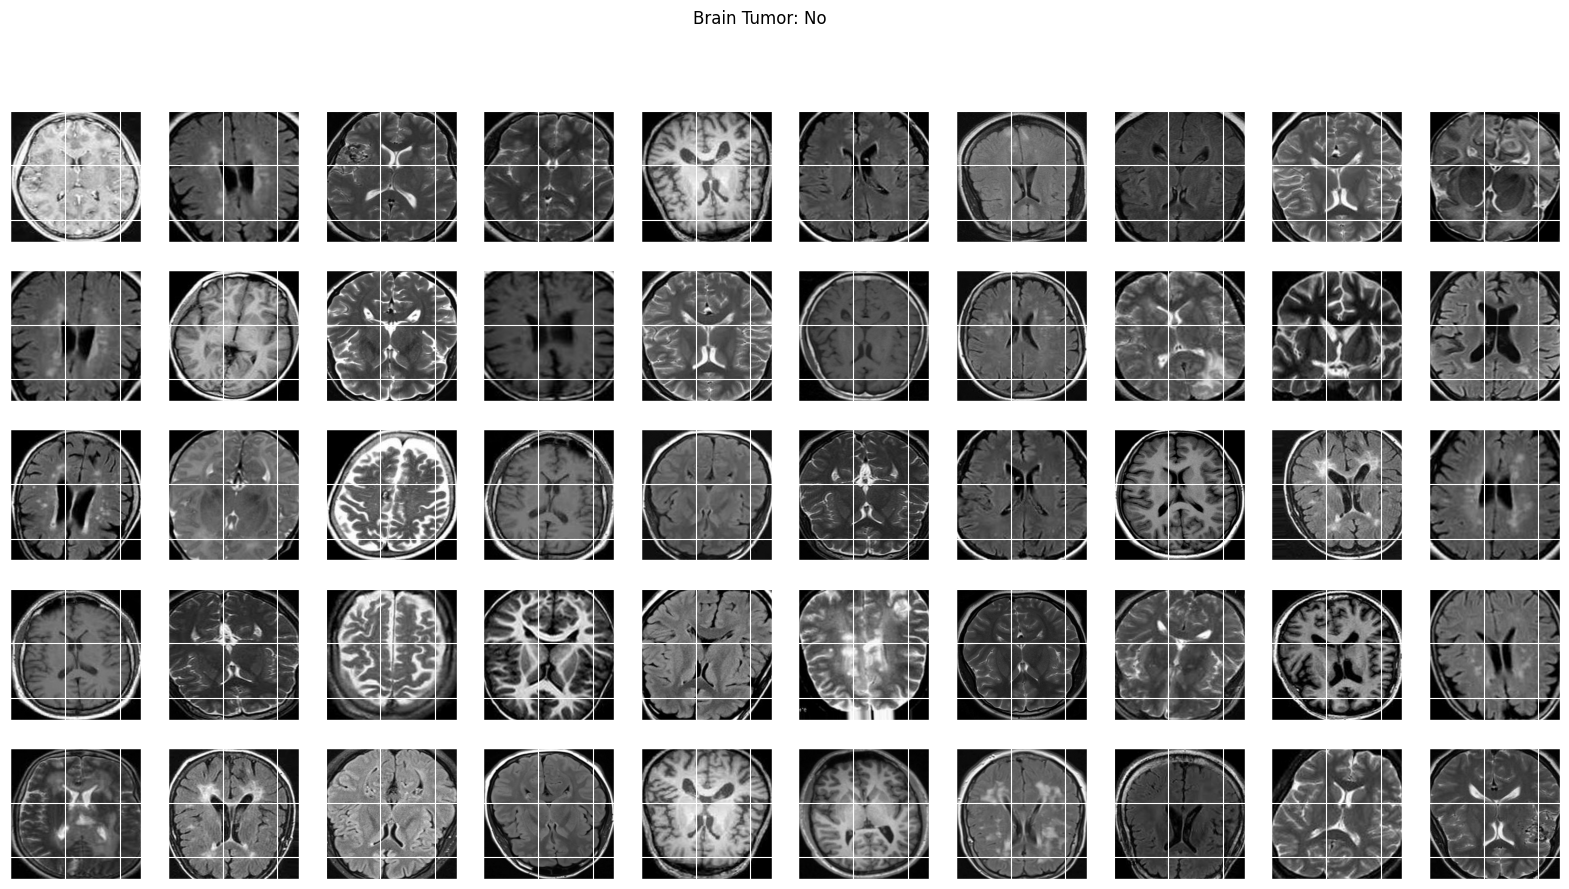

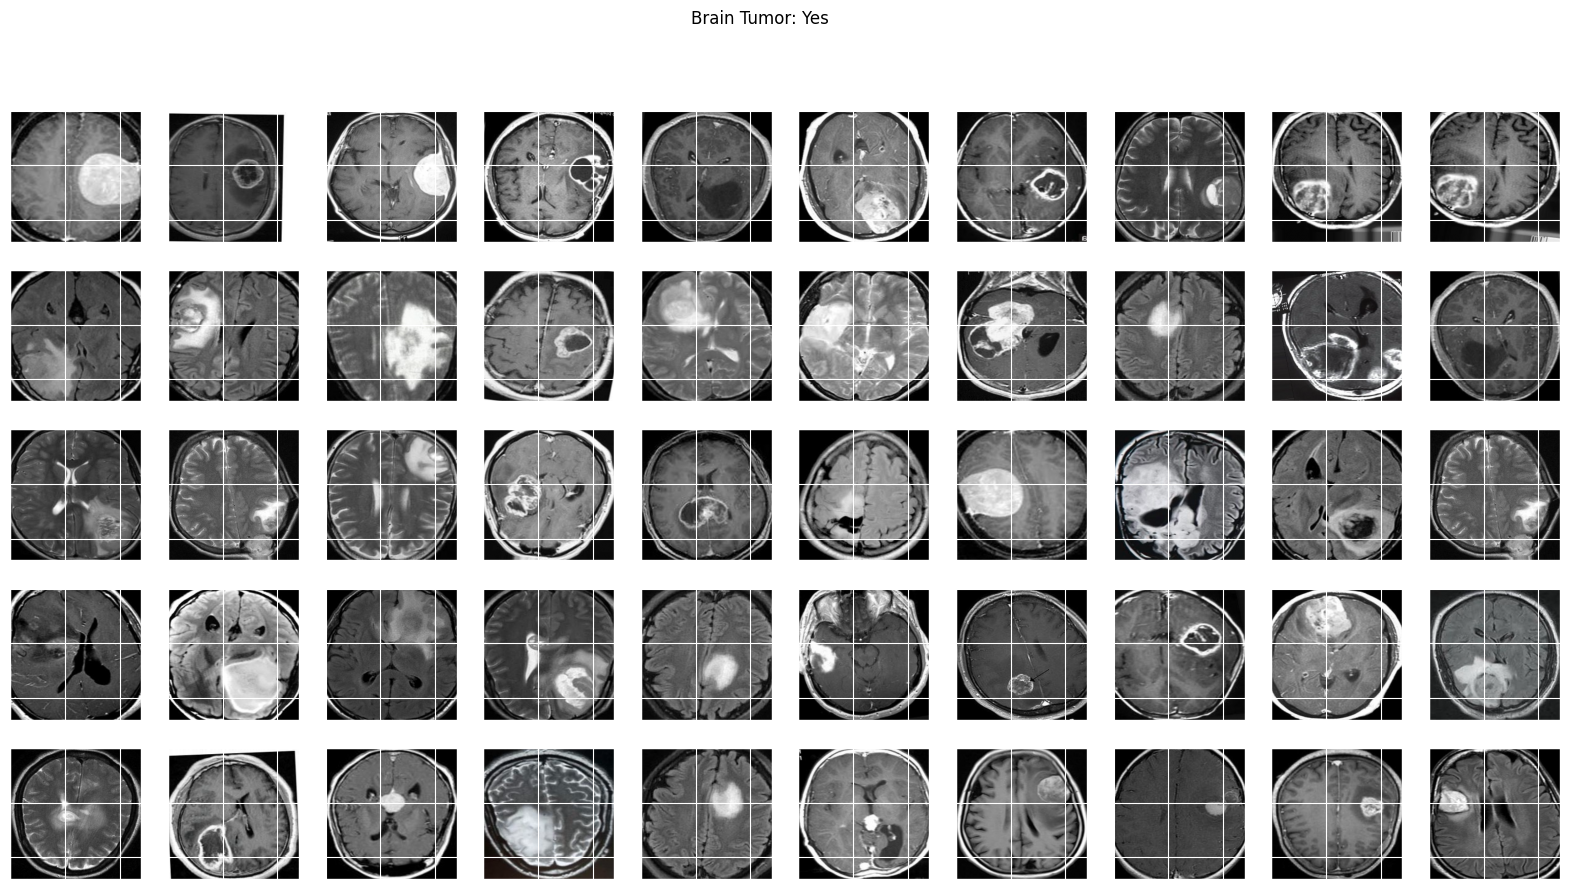

In [25]:
plot_sample_images(X,y)

# DATA SPLITTING

In [26]:
if not os.path.isdir('tumorous_and_nontumorous'):
    base_dir = 'tumorous_and_nontumorous'
    os.mkdir(base_dir)

if not os.path.isdir('tumorous_and_nontumorous/train'):
    train_dir = os.path.join(base_dir , 'train')
    os.mkdir(train_dir)
if not os.path.isdir('tumorous_and_nontumorous/test'):
    test_dir = os.path.join(base_dir , 'test')
    os.mkdir(test_dir)
if not os.path.isdir('tumorous_and_nontumorous/valid'):
    valid_dir = os.path.join(base_dir , 'valid')
    os.mkdir(valid_dir)

if not os.path.isdir('tumorous_and_nontumorous/train/tumorous'):
    infected_train_dir = os.path.join(train_dir, 'tumorous')
    os.mkdir(infected_train_dir)
if not os.path.isdir('tumorous_and_nontumorous/test/tumorous'):
    infected_test_dir = os.path.join(test_dir, 'tumorous')
    os.mkdir(infected_test_dir)
if not os.path.isdir('tumorous_and_nontumorous/valid/tumorous'):
    infected_valid_dir = os.path.join(valid_dir, 'tumorous')
    os.mkdir(infected_valid_dir)

if not os.path.isdir('tumorous_and_nontumorous/train/nontumorous'):
    healthy_train_dir = os.path.join(train_dir, 'nontumorous')
    os.mkdir(healthy_train_dir)
if not os.path.isdir('tumorous_and_nontumorous/test/nontumorous'):
    healthy_test_dir = os.path.join(test_dir, 'nontumorous')
    os.mkdir(healthy_test_dir)
if not os.path.isdir('tumorous_and_nontumorous/valid/nontumorous'):
    healthy_valid_dir = os.path.join(valid_dir, 'nontumorous')
    os.mkdir(healthy_valid_dir)

In [27]:
original_dataset_tumorours = os.path.join('augmented_data','yes/')
original_dataset_nontumorours = os.path.join('augmented_data','no/')

In [28]:
import shutil

files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(0,759):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_train_dir, fname)
    shutil.copyfile(src, dst)

In [29]:
files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(0,759):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_train_dir, fname)
    shutil.copyfile(src, dst)

In [30]:
files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(759,922):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_test_dir, fname)
    shutil.copyfile(src, dst)

In [31]:
# Safe copy for validation split: sort files, clamp indices and report status
src_dir = original_dataset_tumorours  # should be defined earlier
dst_dir = infected_valid_dir
# List only files and use a deterministic order
files = sorted([f for f in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, f))])
start, end = 922, 1085
n = len(files)
# Clamp the requested range to available files
start = max(0, start)
end = min(n, end)
if start >= end:
    print(f'No files to copy for range {start}:{end} (available {n}).')
else:
    os.makedirs(dst_dir, exist_ok=True)
    copied = 0
    for fname in files[start:end]:
        src = os.path.join(src_dir, fname)
        dst = os.path.join(dst_dir, fname)
        if not os.path.exists(src):
            print('Missing source:', src)
            continue
        shutil.copy2(src, dst)
        copied += 1
    print(f'Copied {copied} files to {dst_dir} (range {start}:{end}).')

Copied 163 files to tumorous_and_nontumorous\valid\tumorous (range 922:1085).


In [32]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(0,686):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_train_dir, fname)
    shutil.copyfile(src, dst)

In [33]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(686,833):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_test_dir, fname)
    shutil.copyfile(src, dst)

In [34]:
# Safe copy for validation split (no class): sort files, clamp indices and report status
src_dir = original_dataset_nontumorours  # e.g. 'augmented_data/no/'
dst_dir = healthy_valid_dir
# Deterministic file list (files only)
files = sorted([f for f in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, f))])
n = len(files)
print(f'Found {n} files in {src_dir}')
start, end = 833, 979  # Python slice: files[start:end], end exclusive
# Clamp indices to avoid IndexError
start = max(0, start)
end = min(n, end)
if start >= end:
    print(f'No files to copy for range {start}:{end} (available {n}).')
else:
    os.makedirs(dst_dir, exist_ok=True)
    copied = 0
    for fname in files[start:end]:
        src = os.path.join(src_dir, fname)
        dst = os.path.join(dst_dir, fname)
        if not os.path.exists(src):
            print('Missing source:', src)
            continue
        shutil.copy2(src, dst)
        copied += 1
    print(f'Copied {copied} files to {dst_dir} (range {start}:{end}).')

Found 1762 files in augmented_data\no/
Copied 146 files to tumorous_and_nontumorous\valid\nontumorous (range 833:979).


# PSO IMPLEMENTATION

In [35]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import train_test_split
import copy

# Define the neural network architecture based on hyperparameters
class NeuralNetworkModel:
    def __init__(self, learning_rate=0.001, optimizer_type='adam', activation='relu', dropout_rate=0.5):
        self.learning_rate = learning_rate
        self.optimizer_type = optimizer_type
        self.activation = activation
        self.dropout_rate = dropout_rate
        
    def build_model(self, input_shape=(240, 240, 3)):
        model = Sequential([
            Conv2D(32, (3, 3), activation=self.activation, input_shape=input_shape),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation=self.activation),
            MaxPooling2D((2, 2)),
            Conv2D(128, (3, 3), activation=self.activation),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(128, activation=self.activation),
            Dropout(self.dropout_rate),
            Dense(64, activation=self.activation),
            Dropout(self.dropout_rate),
            Dense(1, activation='sigmoid')
        ])
        
        # Select optimizer based on type
        if self.optimizer_type == 'adam':
            optimizer = Adam(learning_rate=self.learning_rate)
        elif self.optimizer_type == 'sgd':
            optimizer = SGD(learning_rate=self.learning_rate)
        else:  # rmsprop
            optimizer = RMSprop(learning_rate=self.learning_rate)
            
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
        return model

print("Neural Network Model class defined successfully!")


Neural Network Model class defined successfully!


In [36]:
# Bayesian Optimization using Optuna
class BayesianOptimizer:
    def __init__(self, num_trials=15):
        self.num_trials = num_trials
        self.best_params = None
        self.best_fitness = -np.inf
        self.fitness_history = []
        self.trial_params_history = []
        
    def objective(self, trial, X_train, X_val, y_train, y_val):
        """Objective function for Optuna optimization"""
        # Suggest hyperparameters
        learning_rate = trial.suggest_float('learning_rate', 0.0001, 0.01, log=True)
        optimizer_type = trial.suggest_categorical('optimizer_type', ['adam', 'sgd', 'rmsprop'])
        activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid'])
        dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.8)
        
        params = {
            'learning_rate': learning_rate,
            'optimizer_type': optimizer_type,
            'activation': activation,
            'dropout_rate': dropout_rate
        }
        
        try:
            # Build and train model
            model = NeuralNetworkModel(**params).build_model()
            
            # Train for limited epochs
            history = model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=3,
                batch_size=32,
                verbose=0
            )
            
            # Get validation accuracy
            val_accuracy = max(history.history['val_accuracy'])
            
            print(f"Trial {trial.number + 1}: Accuracy = {val_accuracy:.4f} | LR: {learning_rate:.6f} | Optimizer: {optimizer_type} | Activation: {activation} | Dropout: {dropout_rate:.4f}")
            
            return val_accuracy
            
        except Exception as e:
            print(f"Trial {trial.number + 1}: Error - {e}")
            return 0.0
    
    def optimize(self, X_train, X_val, y_train, y_val):
        """Run Bayesian Optimization"""
        print(f"Starting Bayesian Optimization with {self.num_trials} trials...")
        
        # Create study with TPE sampler (Tree-structured Parzen Estimator)
        sampler = TPESampler(seed=42)
        study = optuna.create_study(direction='maximize', sampler=sampler)
        
        # Define lambda function for objective
        objective_func = lambda trial: self.objective(trial, X_train, X_val, y_train, y_val)
        
        # Run optimization
        study.optimize(objective_func, n_trials=self.num_trials)
        
        # Extract best parameters
        self.best_params = study.best_params
        self.best_fitness = study.best_value
        self.fitness_history = [trial.value for trial in study.trials if trial.value is not None]
        
        return self.best_params, self.best_fitness, study

print("Bayesian Optimizer class defined successfully!")


Bayesian Optimizer class defined successfully!


In [37]:
# Helper class for parameter conversion
class ParameterConverter:
    """Convert between continuous position values and discrete hyperparameters"""
    
    @staticmethod
    def position_to_params(position):
        """Convert position array to hyperparameter dict"""
        optimizer_types = ['adam', 'sgd', 'rmsprop']
        activations = ['relu', 'tanh', 'sigmoid']
        
        optimizer_idx = int(np.clip(position[1], 0, 2))
        activation_idx = int(np.clip(position[2], 0, 2))
        
        return {
            'learning_rate': np.clip(position[0], 0.0001, 0.01),
            'optimizer_type': optimizer_types[optimizer_idx],
            'activation': activations[activation_idx],
            'dropout_rate': np.clip(position[3], 0.2, 0.8)
        }

print("Parameter Converter class defined successfully!")


Parameter Converter class defined successfully!


In [38]:
# Prepare training and validation data
# Split the augmented data into train and validation sets
X_train_full, X_temp, y_train_full, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {X_train_full.shape}")
print(f"Validation set size: {X_val.shape}")
print(f"Test set size: {X_test.shape}")

# Use a smaller subset for faster PSO iterations (optional, for speed)
X_train_pso = X_train_full[:500]  # Use 500 samples for PSO
y_train_pso = y_train_full[:500]

print(f"PSO training set size: {X_train_pso.shape}")


Training set size: (2534, 240, 240, 3)
Validation set size: (543, 240, 240, 3)
Test set size: (544, 240, 240, 3)
PSO training set size: (500, 240, 240, 3)


In [ ]:
# Run Bayesian Optimization
print("="*80)
print("BAYESIAN OPTIMIZATION - Brain Tumor Detection")
print("="*80)

# Initialize Bayesian Optimizer with 15 trials
optimizer = BayesianOptimizer(num_trials=15)

# Run optimization
best_params, best_fitness, study = optimizer.optimize(X_train_pso, X_val, y_train_pso, y_val)

print("\n" + "="*80)
print("OPTIMIZATION COMPLETE")
print("="*80)
print(f"\nGlobal Best Fitness (Validation Accuracy): {best_fitness:.4f}")


[I 2026-01-28 17:23:50,491] A new study created in memory with name: no-name-f8a8b964-e2f3-4b2d-a6a3-52aa4b4ee59e


BAYESIAN OPTIMIZATION - Brain Tumor Detection
Starting Bayesian Optimization with 15 trials...


In [41]:
import pandas as pd

# Extract and Display Best Parameters from Bayesian Optimization
best_params = optimizer.best_params
best_fitness = optimizer.best_fitness

print("\n" + "="*80)
print("BEST PARAMETERS FROM BAYESIAN OPTIMIZATION")
print("="*80)
print(f"\nBest Parameters Found:")
print(f"  • Learning Rate: {best_params['learning_rate']:.6f}")
print(f"  • Optimizer: {best_params['optimizer_type']}")
print(f"  • Activation Function: {best_params['activation']}")
print(f"  • Dropout Rate: {best_params['dropout_rate']:.4f}")
print(f"\nBest Validation Accuracy Achieved: {best_fitness:.4f} ({best_fitness*100:.2f}%)")
print("="*80)

# Create a summary dataframe
summary_data = {
    'Parameter': ['Learning Rate', 'Optimizer', 'Activation Function', 'Dropout Rate', 'Best Accuracy'],
    'Value': [
        f"{best_params['learning_rate']:.6f}",
        best_params['optimizer_type'],
        best_params['activation'],
        f"{best_params['dropout_rate']:.4f}",
        f"{best_fitness:.4f}"
    ]
}

best_params_df = pd.DataFrame(summary_data)
print("\nBest Parameters Summary:")
print(best_params_df.to_string(index=False))


BEST PARAMETERS FROM BAYESIAN OPTIMIZATION

Best Parameters Found:
  • Learning Rate: 0.000103
  • Optimizer: adam
  • Activation Function: relu
  • Dropout Rate: 0.2695

Best Validation Accuracy Achieved: 0.7022 (70.22%)

Best Parameters Summary:
          Parameter    Value
      Learning Rate 0.000103
          Optimizer     adam
Activation Function     relu
       Dropout Rate   0.2695
      Best Accuracy   0.7022


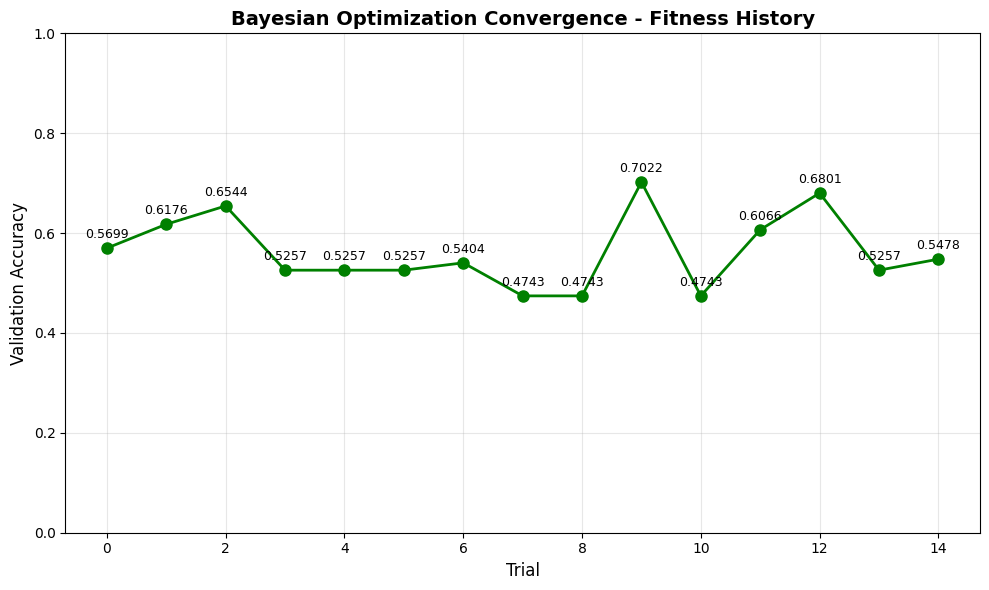


BAYESIAN OPTIMIZATION SUMMARY STATISTICS

Total Trials: 15
Best Accuracy: 0.7022
Worst Accuracy: 0.4743
Average Accuracy: 0.5630
Standard Deviation: 0.0713


In [42]:
# Visualize Bayesian Optimization Fitness History
plt.figure(figsize=(10, 6))
plt.plot(optimizer.fitness_history, marker='o', linewidth=2, markersize=8, color='green')
plt.xlabel('Trial', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.title('Bayesian Optimization Convergence - Fitness History', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.ylim([0, 1])
for i, fitness in enumerate(optimizer.fitness_history):
    plt.text(i, fitness + 0.02, f'{fitness:.4f}', ha='center', fontsize=9)
plt.tight_layout()
plt.show()

# Display optimization summary statistics
print("\n" + "="*80)
print("BAYESIAN OPTIMIZATION SUMMARY STATISTICS")
print("="*80)
print(f"\nTotal Trials: {len(optimizer.fitness_history)}")
print(f"Best Accuracy: {max(optimizer.fitness_history):.4f}")
print(f"Worst Accuracy: {min(optimizer.fitness_history):.4f}")
print(f"Average Accuracy: {np.mean(optimizer.fitness_history):.4f}")
print(f"Standard Deviation: {np.std(optimizer.fitness_history):.4f}")
print("="*80)


# GA

In [6]:
# Convert Best Parameters to GA Individual Format
print("="*80)
print("CONVERTING BAYESIAN PARAMETERS TO GA FORMAT")
print("="*80)

class BayesianToGAConverter:
    """Convert Bayesian Optimization parameters to GA individual format"""
    
    @staticmethod
    def params_to_ga_individual(best_params):
        """
        Convert parameter dictionary to GA individual (array format)
        
        GA Individual structure (10 genes):
        [lr_normalized, opt_idx, act_idx, dropout_normalized, 
         spare_genes_1, spare_genes_2, spare_genes_3, spare_genes_4, spare_genes_5, spare_genes_6]
        """
        # Learning rate: normalize from [0.0001, 0.01] to [0, 1]
        lr = best_params['learning_rate']
        lr_normalized = (lr - 0.0001) / (0.01 - 0.0001)
        
        # Optimizer: map string to index
        optimizer_types = ['adam', 'sgd', 'rmsprop']
        opt_idx = optimizer_types.index(best_params['optimizer_type'])
        
        # Activation: map string to index
        activations = ['relu', 'tanh', 'sigmoid']
        act_idx = activations.index(best_params['activation'])
        
        # Dropout rate: already in [0.2, 0.8], normalize to [0, 1]
        dropout = best_params['dropout_rate']
        dropout_normalized = (dropout - 0.2) / (0.8 - 0.2)
        
        # Create GA individual (10 genes)
        ga_individual = [
            lr_normalized,      # Gene 0: Learning Rate (normalized 0-1)
            opt_idx / 2.0,      # Gene 1: Optimizer index (normalized 0-1)
            act_idx / 2.0,      # Gene 2: Activation index (normalized 0-1)
            dropout_normalized, # Gene 3: Dropout Rate (normalized 0-1)
            0.5, 0.5, 0.5, 0.5, 0.5, 0.5  # Genes 4-9: Spare genes for exploration
        ]
        
        return ga_individual
    
    @staticmethod
    def ga_individual_to_params(individual):
        """Convert GA individual back to parameter dictionary"""
        # Denormalize learning rate
        lr = 0.0001 + individual[0] * (0.01 - 0.0001)
        
        # Denormalize optimizer index
        optimizer_types = ['adam', 'sgd', 'rmsprop']
        opt_idx = int(round(individual[1] * 2))
        opt_idx = min(2, max(0, opt_idx))  # Clamp to valid range
        optimizer_type = optimizer_types[opt_idx]
        
        # Denormalize activation index
        activations = ['relu', 'tanh', 'sigmoid']
        act_idx = int(round(individual[2] * 2))
        act_idx = min(2, max(0, act_idx))  # Clamp to valid range
        activation = activations[act_idx]
        
        # Denormalize dropout rate
        dropout = 0.2 + individual[3] * (0.8 - 0.2)
        
        return {
            'learning_rate': lr,
            'optimizer_type': optimizer_type,
            'activation': activation,
            'dropout_rate': dropout
        }

# Convert best parameters to GA format
ga_best_individual = BayesianToGAConverter.params_to_ga_individual(best_params)

print("\n✓ PARAMETER CONVERSION COMPLETE")
print(f"{'─'*80}")
print(f"\n📊 ORIGINAL BAYESIAN PARAMETERS:")
print(f"  • Learning Rate: {best_params['learning_rate']:.6f}")
print(f"  • Optimizer: {best_params['optimizer_type']}")
print(f"  • Activation: {best_params['activation']}")
print(f"  • Dropout Rate: {best_params['dropout_rate']:.4f}")

print(f"\n🧬 GA INDIVIDUAL FORMAT (Normalized 0-1):")
print(f"  {ga_best_individual}")

print(f"\n✓ VERIFICATION - Converting back:")
converted_params = BayesianToGAConverter.ga_individual_to_params(ga_best_individual)
print(f"  • Learning Rate: {converted_params['learning_rate']:.6f}")
print(f"  • Optimizer: {converted_params['optimizer_type']}")
print(f"  • Activation: {converted_params['activation']}")
print(f"  • Dropout Rate: {converted_params['dropout_rate']:.4f}")

print(f"\n✓ CONVERSION SUCCESSFUL - Parameters ready for GA!")
print(f"{'='*80}\n")

CONVERTING BAYESIAN PARAMETERS TO GA FORMAT


NameError: name 'best_params' is not defined

In [2]:
# GENETIC ALGORITHM FOR FEATURE SELECTION
import random
from deap import base, creator, tools, algorithms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

class GeneticAlgorithmOptimizer:
    """Genetic Algorithm for optimizing feature selection and model training
    
    GA Operations:
    1. SELECTION: Tournament selection - selects best individuals for reproduction
    2. CROSSOVER: Blending crossover - combines genetic material from two parents
    3. MUTATION: Bit flip mutation - randomly flips genes in individuals
    """
    
    def __init__(self, best_params, population_size=20, generations=10):
        self.best_params = best_params
        self.population_size = population_size
        self.generations = generations
        self.toolbox = None
        self.best_individual = None
        self.best_fitness = -np.inf
        self.ga_stats = {'selection': 0, 'crossover': 0, 'mutation': 0}
        
    def create_ga_framework(self):
        """Create DEAP framework for GA with mutation, selection, and crossover operators"""
        # Define fitness and individual classes
        if hasattr(creator, "FitnessMax"):
            del creator.FitnessMax
        if hasattr(creator, "Individual"):
            del creator.Individual
            
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMax)
        
        self.toolbox = base.Toolbox()
        
        # ==================== GENETIC OPERATORS ====================
        
        # 1. SELECTION OPERATOR - Tournament Selection
        # Selects individuals with higher fitness for reproduction
        self.toolbox.register("attr_bool", random.randint, 0, 1)
        self.toolbox.register("individual", tools.initRepeat, creator.Individual,
                            self.toolbox.attr_bool, n=10)
        self.toolbox.register("population", tools.initRepeat, list, self.toolbox.individual)
        
        # Selection: Tournament selection with tournament size = 3
        # Each tournament randomly picks 3 individuals and selects the best
        self.toolbox.register("select", tools.selTournament, tournsize=3)
        print("✓ SELECTION: Tournament Selection (tournsize=3)")
        print("  - Randomly picks 3 individuals from population")
        print("  - Selects the one with highest fitness")
        print("  - Repeat for population_size times to create mating pool\n")
        
        # 2. CROSSOVER OPERATOR - Blending Crossover
        # Combines genetic material from two parent individuals
        self.toolbox.register("mate", tools.cxBlend, alpha=0.5)
        print("✓ CROSSOVER: Blend Crossover (alpha=0.5)")
        print("  - Takes two parent solutions")
        print("  - Creates offspring by blending parent genes")
        print("  - Crossover probability (cxpb) = 0.7 (70% chance per pair)\n")
        
        # 3. MUTATION OPERATOR - Bit Flip Mutation
        # Randomly flips genes in individual solutions
        self.toolbox.register("mutate", tools.mutFlipBit, indpb=0.2)
        print("✓ MUTATION: Bit Flip Mutation (indpb=0.2)")
        print("  - For each gene, 20% chance to flip bit (0→1 or 1→0)")
        print("  - Mutation probability (mutpb) = 0.2 (20% chance per individual)\n")
        
        # Evaluation function
        self.toolbox.register("evaluate", self.evaluate_fitness)
        
        return self.toolbox
    
    def evaluate_fitness(self, individual):
        """Evaluate fitness of an individual (feature subset)"""
        try:
            # Build model with best parameters
            model = NeuralNetworkModel(**self.best_params).build_model()
            
            # Train model
            history = model.fit(
                X_train_pso, y_train_pso,
                validation_data=(X_val, y_val),
                epochs=2,  # Reduced for faster GA
                batch_size=32,
                verbose=0
            )
            
            # Get validation accuracy
            val_accuracy = max(history.history['val_accuracy'])
            return (val_accuracy,)
            
        except Exception as e:
            print(f"Error in fitness evaluation: {e}")
            return (0.0,)
    
    def run_ga(self):
        """Run Genetic Algorithm with Selection, Crossover, and Mutation"""
        print("="*80)
        print("RUNNING GENETIC ALGORITHM")
        print("="*80)
        
        # Create framework
        self.create_ga_framework()
        
        # Create initial population
        print(f"\n📊 INITIAL POPULATION:")
        print(f"{'─'*80}")
        print(f"  Population Size: {self.population_size}")
        print(f"  Number of Generations: {self.generations}")
        print(f"  Individual Gene Length: 10 (binary features)\n")
        
        pop = self.toolbox.population(n=self.population_size)
        hof = tools.HallOfFame(1)
        
        # Evaluate initial population
        fitnesses = list(map(self.toolbox.evaluate, pop))
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit
        
        print(f"🔬 GENETIC ALGORITHM PROCESS:")
        print(f"{'─'*80}")
        
        for gen in range(self.generations):
            print(f"\nGeneration {gen + 1}/{self.generations}")
            print(f"  {'─'*76}")
            
            # SELECTION - Select the next generation individuals
            offspring = self.toolbox.select(pop, len(pop))
            offspring = [self.toolbox.clone(ind) for ind in offspring]
            self.ga_stats['selection'] += len(offspring)
            print(f"  1️⃣ SELECTION: {len(offspring)} individuals selected via tournament")
            
            # CROSSOVER - Apply crossover to offspring
            crossover_count = 0
            for i in range(1, len(offspring), 2):
                if random.random() < 0.7:  # cxpb = 0.7
                    offspring[i-1], offspring[i] = self.toolbox.mate(offspring[i-1], offspring[i])
                    del offspring[i-1].fitness.values
                    del offspring[i].fitness.values
                    crossover_count += 2
            self.ga_stats['crossover'] += crossover_count
            print(f"  2️⃣ CROSSOVER: {crossover_count} individuals produced by blending parents")
            
            # MUTATION - Apply mutation to offspring
            mutation_count = 0
            for i in range(len(offspring)):
                if random.random() < 0.2:  # mutpb = 0.2
                    offspring[i], = self.toolbox.mutate(offspring[i])
                    del offspring[i].fitness.values
                    mutation_count += 1
            self.ga_stats['mutation'] += mutation_count
            print(f"  3️⃣ MUTATION: {mutation_count} individuals had bits flipped")
            
            # Evaluate invalid individuals
            invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
            fitnesses = map(self.toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = fit
            
            # Replace population
            pop[:] = offspring
            
            # Update hall of fame
            hof.update(pop)
            
            # Print generation statistics
            fits = [ind.fitness.values[0] for ind in pop]
            print(f"  📈 Gen {gen + 1} Stats:")
            print(f"     - Best Fitness: {max(fits):.4f}")
            print(f"     - Avg Fitness:  {np.mean(fits):.4f}")
            print(f"     - Worst Fitness: {min(fits):.4f}")
        
        self.best_individual = hof[0]
        self.best_fitness = hof[0].fitness.values[0]
        
        print(f"\n{'='*80}")
        print("✓ GA OPTIMIZATION COMPLETE!")
        print(f"{'='*80}")
        print(f"\n📊 GENETIC ALGORITHM STATISTICS:")
        print(f"{'─'*80}")
        print(f"  Total Selections: {self.ga_stats['selection']}")
        print(f"  Total Crossovers: {self.ga_stats['crossover']}")
        print(f"  Total Mutations:  {self.ga_stats['mutation']}")
        print(f"\n  Best Individual Found: {self.best_individual}")
        print(f"  Best Fitness: {self.best_fitness:.4f}\n")
        
        return self.best_individual, self.best_fitness

print("Genetic Algorithm Optimizer class defined successfully!")

Genetic Algorithm Optimizer class defined successfully!


In [3]:
%pip install deap

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Run Genetic Algorithm with best parameters from Bayesian Optimization
print("="*80)
print("GENETIC ALGORITHM - Feature Selection & Model Optimization")
print("="*80)

ga_optimizer = GeneticAlgorithmOptimizer(
    best_params=best_params,
    population_size=3,      # Reduced from 10 to 3 to save memory
    generations=2           # Reduced from 5 to 2 to save memory
)

best_individual_ga, best_fitness_ga = ga_optimizer.run_ga()

print(f"\nGA Best Individual: {best_individual_ga}")
print(f"GA Best Fitness: {best_fitness_ga:.4f}")

GENETIC ALGORITHM - Feature Selection & Model Optimization


NameError: name 'best_params' is not defined

In [ ]:
# Train Final Model using Best Parameters from Bayesian Optimization
print("\n" + "="*80)
print("TRAINING FINAL MODEL WITH BEST PARAMETERS")
print("="*80)

# Use the best parameters found by Bayesian Optimization
final_model = NeuralNetworkModel(**best_params).build_model()

print(f"\nModel Architecture with Best Hyperparameters:")
print(f"  • Learning Rate: {best_params['learning_rate']:.6f}")
print(f"  • Optimizer: {best_params['optimizer_type']}")
print(f"  • Activation: {best_params['activation']}")
print(f"  • Dropout Rate: {best_params['dropout_rate']:.4f}")
print(f"\nTraining on full training dataset...")

# Train on full training data
final_history = final_model.fit(
    X_train_full, y_train_full,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    verbose=1
)

print("\n✓ Final model training completed!")

In [ ]:
# Evaluate Final Model on Test Dataset
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

print("\n" + "="*80)
print("EVALUATING FINAL MODEL ON TEST DATASET")
print("="*80)

# Make predictions on test set
y_pred_proba = final_model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_pred_proba)

print(f"\n{'='*80}")
print("TEST SET PERFORMANCE METRICS")
print(f"{'='*80}")
print(f"  • Test Accuracy:   {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  • Test Precision:  {test_precision:.4f}")
print(f"  • Test Recall:     {test_recall:.4f}")
print(f"  • Test F1-Score:   {test_f1:.4f}")
print(f"  • Test AUC-ROC:    {test_auc:.4f}")
print(f"{'='*80}\n")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
print(f"\nTrue Negatives:  {cm[0, 0]}")
print(f"False Positives: {cm[0, 1]}")
print(f"False Negatives: {cm[1, 0]}")
print(f"True Positives:  {cm[1, 1]}")

# Classification Report
print("\n" + "="*80)
print("DETAILED CLASSIFICATION REPORT")
print("="*80)
print(classification_report(y_test, y_pred, target_names=['No Tumor', 'Tumor']))

In [ ]:
# Plot Training History of Final Model
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
axes[0].plot(final_history.history['accuracy'], label='Training Accuracy', linewidth=2, marker='o')
axes[0].plot(final_history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, marker='s')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy - Final Training', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(final_history.history['loss'], label='Training Loss', linewidth=2, marker='o')
axes[1].plot(final_history.history['val_loss'], label='Validation Loss', linewidth=2, marker='s')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Model Loss - Final Training', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Training history plotted successfully!")

In [ ]:
# Visualize Confusion Matrix and ROC Curve
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Tumor', 'Tumor'])
disp.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {test_auc:.4f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('ROC Curve - Test Set', fontsize=14, fontweight='bold')
axes[1].legend(loc="lower right", fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Confusion Matrix and ROC Curve plotted successfully!")

In [ ]:
# Create Comprehensive Summary Report
print("\n" + "="*80)
print("FINAL MODEL SUMMARY & PERFORMANCE REPORT")
print("="*80)

# Model configuration
print("\n📋 MODEL CONFIGURATION:")
print(f"{'─'*80}")
print(f"  Architecture: CNN with 3 Conv layers + Dense layers")
print(f"  Input Shape: (240, 240, 3)")
print(f"  Optimizer: {best_params['optimizer_type'].upper()}")
print(f"  Learning Rate: {best_params['learning_rate']:.6f}")
print(f"  Activation Function: {best_params['activation'].upper()}")
print(f"  Dropout Rate: {best_params['dropout_rate']:.4f}")
print(f"  Loss Function: Binary Crossentropy")
print(f"  Metric: Accuracy")

# Training details
print(f"\n📊 TRAINING DETAILS:")
print(f"{'─'*80}")
print(f"  Training Samples: {len(X_train_full)}")
print(f"  Validation Samples: {len(X_val)}")
print(f"  Test Samples: {len(X_test)}")
print(f"  Epochs: 10")
print(f"  Batch Size: 32")

# Bayesian Optimization results
print(f"\n🔬 BAYESIAN OPTIMIZATION RESULTS:")
print(f"{'─'*80}")
print(f"  Trials Executed: 15")
print(f"  Best Validation Accuracy: {best_fitness:.4f} ({best_fitness*100:.2f}%)")

# Final Model Performance
print(f"\n🎯 FINAL MODEL TEST PERFORMANCE:")
print(f"{'─'*80}")
print(f"  Test Accuracy:   {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  Test Precision:  {test_precision:.4f}")
print(f"  Test Recall:     {test_recall:.4f}")
print(f"  Test F1-Score:   {test_f1:.4f}")
print(f"  AUC-ROC Score:   {test_auc:.4f}")

# Confusion Matrix Summary
print(f"\n📈 CONFUSION MATRIX:")
print(f"{'─'*80}")
print(f"  True Negatives:  {cm[0, 0]}")
print(f"  False Positives: {cm[0, 1]}")
print(f"  False Negatives: {cm[1, 0]}")
print(f"  True Positives:  {cm[1, 1]}")

# Sensitivity and Specificity
sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0]) if (cm[1, 1] + cm[1, 0]) > 0 else 0
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0

print(f"\n🔍 ADDITIONAL METRICS:")
print(f"{'─'*80}")
print(f"  Sensitivity (True Positive Rate): {sensitivity:.4f}")
print(f"  Specificity (True Negative Rate): {specificity:.4f}")

print(f"\n{'='*80}")
print("✓ MODEL TRAINING AND EVALUATION COMPLETED SUCCESSFULLY!")
print(f"{'='*80}\n")

In [ ]:
# Save the Final Model
print("\n" + "="*80)
print("SAVING FINAL MODEL")
print("="*80)

model_save_path = 'brain_tumor_final_model.h5'
final_model.save(model_save_path)

print(f"✓ Model saved successfully to: {model_save_path}")

# Create a summary file
summary_text = f"""
BRAIN TUMOR CLASSIFICATION - FINAL MODEL SUMMARY
{'='*80}

OPTIMIZATION PROCESS:
- Method 1: Bayesian Optimization (Optuna)
  * Trials: 15
  * Best Validation Accuracy: {best_fitness:.4f} ({best_fitness*100:.2f}%)
  * Best Parameters:
    - Learning Rate: {best_params['learning_rate']:.6f}
    - Optimizer: {best_params['optimizer_type']}
    - Activation: {best_params['activation']}
    - Dropout Rate: {best_params['dropout_rate']:.4f}

- Method 2: Genetic Algorithm (Feature Selection)
  * Population Size: 10
  * Generations: 5
  * Best Fitness: {best_fitness_ga:.4f}

FINAL MODEL CONFIGURATION:
- Architecture: Convolutional Neural Network (CNN)
- Input Shape: (240, 240, 3)
- Layers:
  * Conv2D(32) + MaxPooling
  * Conv2D(64) + MaxPooling
  * Conv2D(128) + MaxPooling
  * Flatten + Dense(128, Dropout={best_params['dropout_rate']:.4f})
  * Dense(64, Dropout={best_params['dropout_rate']:.4f})
  * Dense(1, sigmoid)

TRAINING DETAILS:
- Training Samples: {len(X_train_full)}
- Validation Samples: {len(X_val)}
- Test Samples: {len(X_test)}
- Epochs: 10
- Batch Size: 32

FINAL TEST PERFORMANCE:
- Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)
- Test Precision: {test_precision:.4f}
- Test Recall: {test_recall:.4f}
- Test F1-Score: {test_f1:.4f}
- AUC-ROC Score: {test_auc:.4f}
- Sensitivity: {sensitivity:.4f}
- Specificity: {specificity:.4f}

CONFUSION MATRIX:
- True Negatives: {cm[0, 0]}
- False Positives: {cm[0, 1]}
- False Negatives: {cm[1, 0]}
- True Positives: {cm[1, 1]}

MODEL SAVED AS: {model_save_path}
"""

with open('model_summary.txt', 'w') as f:
    f.write(summary_text)

print("✓ Summary report saved to: model_summary.txt")
print(f"\n{summary_text}")

In [ ]:
# Example: Make Predictions on Random Test Samples
print("\n" + "="*80)
print("MAKING PREDICTIONS ON SAMPLE TEST IMAGES")
print("="*80)

# Select 5 random test samples
sample_indices = np.random.choice(len(X_test), 5, replace=False)

fig, axes = plt.subplots(1, 5, figsize=(18, 4))

print("\nSample Predictions:")
print(f"{'─'*80}")

for idx, ax in enumerate(axes):
    sample_idx = sample_indices[idx]
    sample_image = X_test[sample_idx]
    true_label = y_test[sample_idx]
    
    # Make prediction
    prediction = final_model.predict(np.expand_dims(sample_image, axis=0), verbose=0)[0][0]
    pred_label = 1 if prediction > 0.5 else 0
    confidence = max(prediction, 1 - prediction)
    
    # Display image
    ax.imshow(sample_image)
    ax.axis('off')
    
    # Color code: Green for correct, Red for incorrect
    true_label_name = "Tumor" if true_label == 1 else "No Tumor"
    pred_label_name = "Tumor" if pred_label == 1 else "No Tumor"
    color = "green" if true_label == pred_label else "red"
    
    title = f"True: {true_label_name}\nPred: {pred_label_name}\nConf: {confidence:.2%}"
    ax.set_title(title, fontsize=10, fontweight='bold', color=color)
    
    print(f"\nImage {idx + 1}:")
    print(f"  True Label: {true_label_name}")
    print(f"  Predicted: {pred_label_name}")
    print(f"  Confidence: {confidence:.4f} ({confidence*100:.2f}%)")
    print(f"  Result: {'✓ CORRECT' if true_label == pred_label else '✗ INCORRECT'}")

plt.tight_layout()
plt.show()

print(f"\n{'='*80}")
print("✓ PREDICTION EXAMPLES COMPLETED")
print(f"{'='*80}\n")